#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import time
from statsmodels.tsa.stattools import adfuller

## Анализ

In [2]:
frame = pd.read_csv('/datasets/taxi.csv',parse_dates =[0],index_col= 0)

In [3]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
frame = frame.sort_index()

In [5]:
#Убедимся, что все прошло корректно
frame.index.is_monotonic

True

In [6]:
frame.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
#заметим, что у нас данные с периодичностью 10 минут, ресемплируем их
frame = frame.resample("1H").sum()

In [8]:
#создадим переменную, для сравнения какая выборка(исходная или полученная путем разности рядов) более стационарная, 
#а так же переменную для создания корректных признаков признаков
frame_new = frame.copy()
final_frame = frame.copy()

In [9]:
frame['rolling_mean'] = frame['num_orders'].rolling(20).mean()
frame['rolling_std'] = frame['num_orders'].rolling(20).std()

**Вывод**


Данные подготовлены к анализу

<AxesSubplot:xlabel='datetime'>

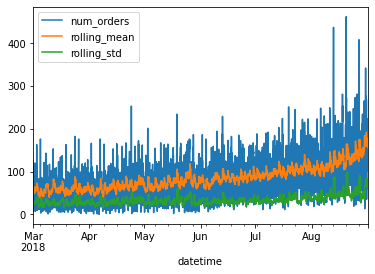

In [10]:
#Посмотрим на данные при помощи графиков
frame.plot()

In [11]:
#Изначально выборка достаточно стационарна, посмотрим ли сильно измениться ситуация, если получить разность ряда
frame_new = frame - frame.shift()

In [12]:
frame_new['rolling_mean'] = frame_new['num_orders'].rolling(20).mean()
frame_new['rolling_std'] = frame_new['num_orders'].rolling(20).std()

<AxesSubplot:xlabel='datetime'>

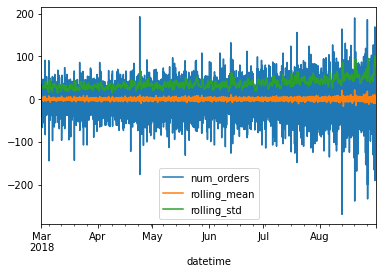

In [13]:
frame_new.plot()

In [14]:
ts = final_frame['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


In [15]:
frame_new.describe()

,num_orders,rolling_mean,rolling_std
count,4415.000000,4396.000000,4396.000000
mean,0.018347,0.024488,37.989795
std,39.023437,2.801253,12.318616
min,-269.000000,-16.650000,14.839049
25%,-22.000000,-1.750000,29.647457
50%,1.000000,-0.050000,35.859650
75%,23.000000,1.650000,43.480720
max,193.000000,21.800000,100.717675


In [16]:
#Удалим все признаки, которые использовались для анализа и создадим новые, которые не будут получены на истинном целевом признаке
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(final_frame,24,20)

<AxesSubplot:title={'center':'Residuals'}, xlabel='datetime'>

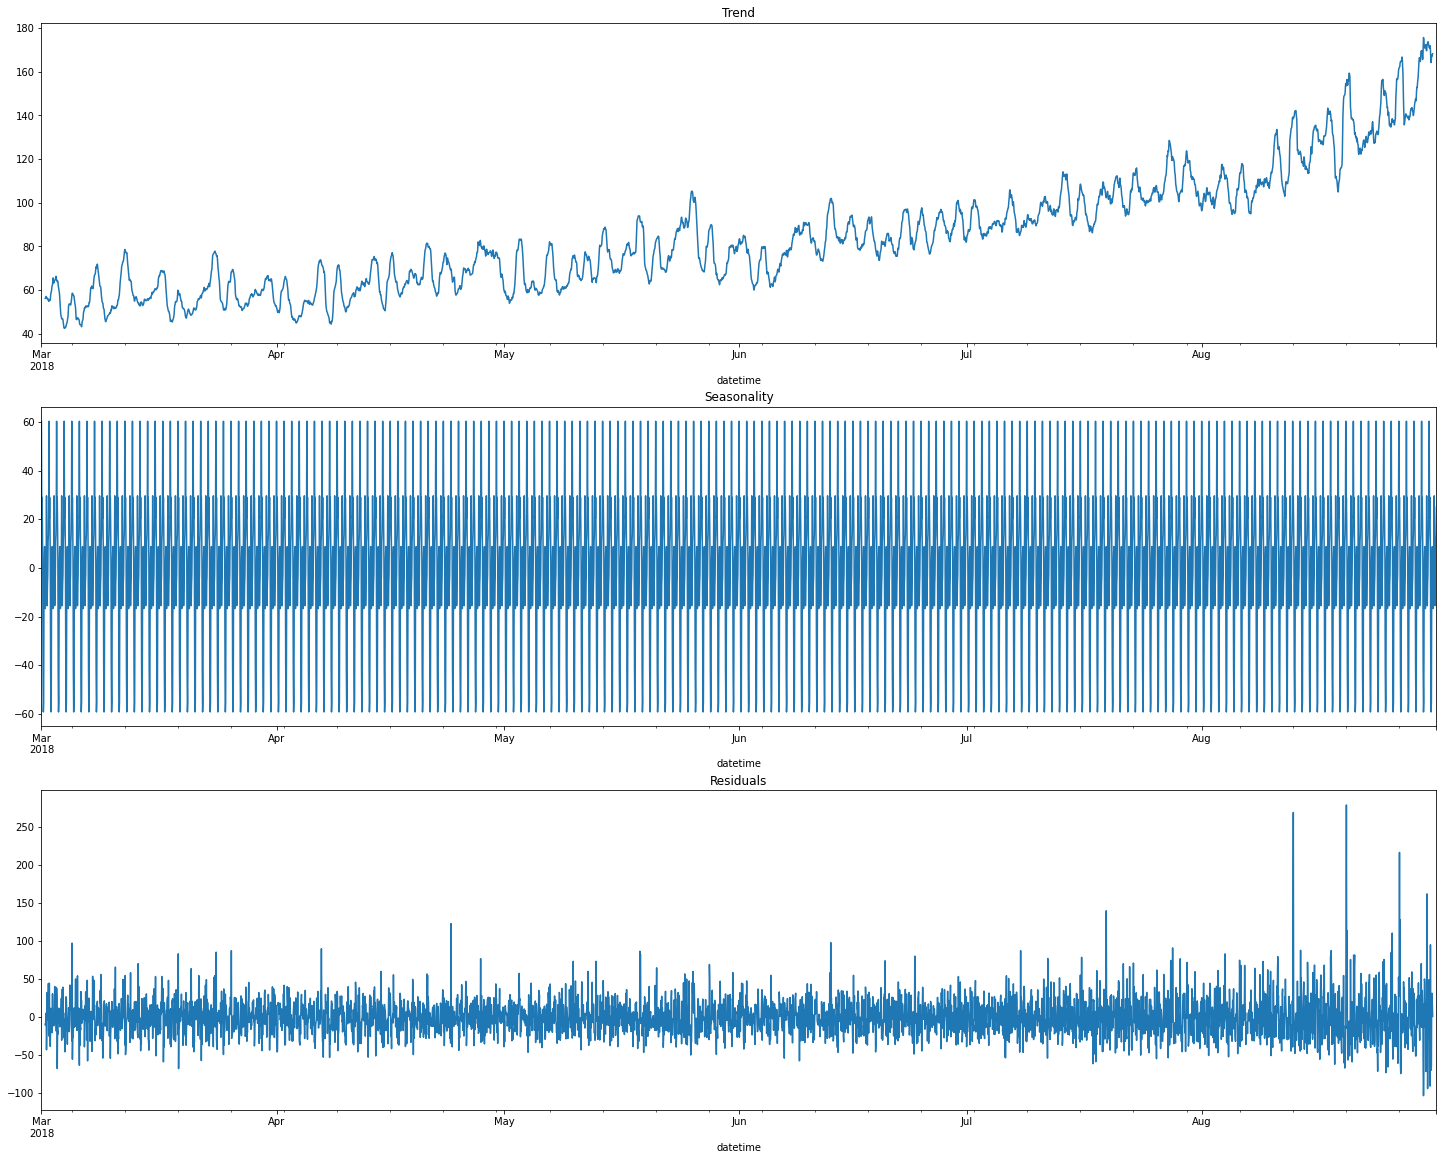

In [18]:
#графики тренда и сезонности
decomposed = seasonal_decompose(final_frame["num_orders"])
fig,ax = plt.subplots(3,1,figsize = (25,20))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. 
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Однако, желательно чтобы сезонность была визуализирована на более коротком интервале!
</div>

Text(0.5, 1.0, 'Seasonality четвертая неделя апреля')

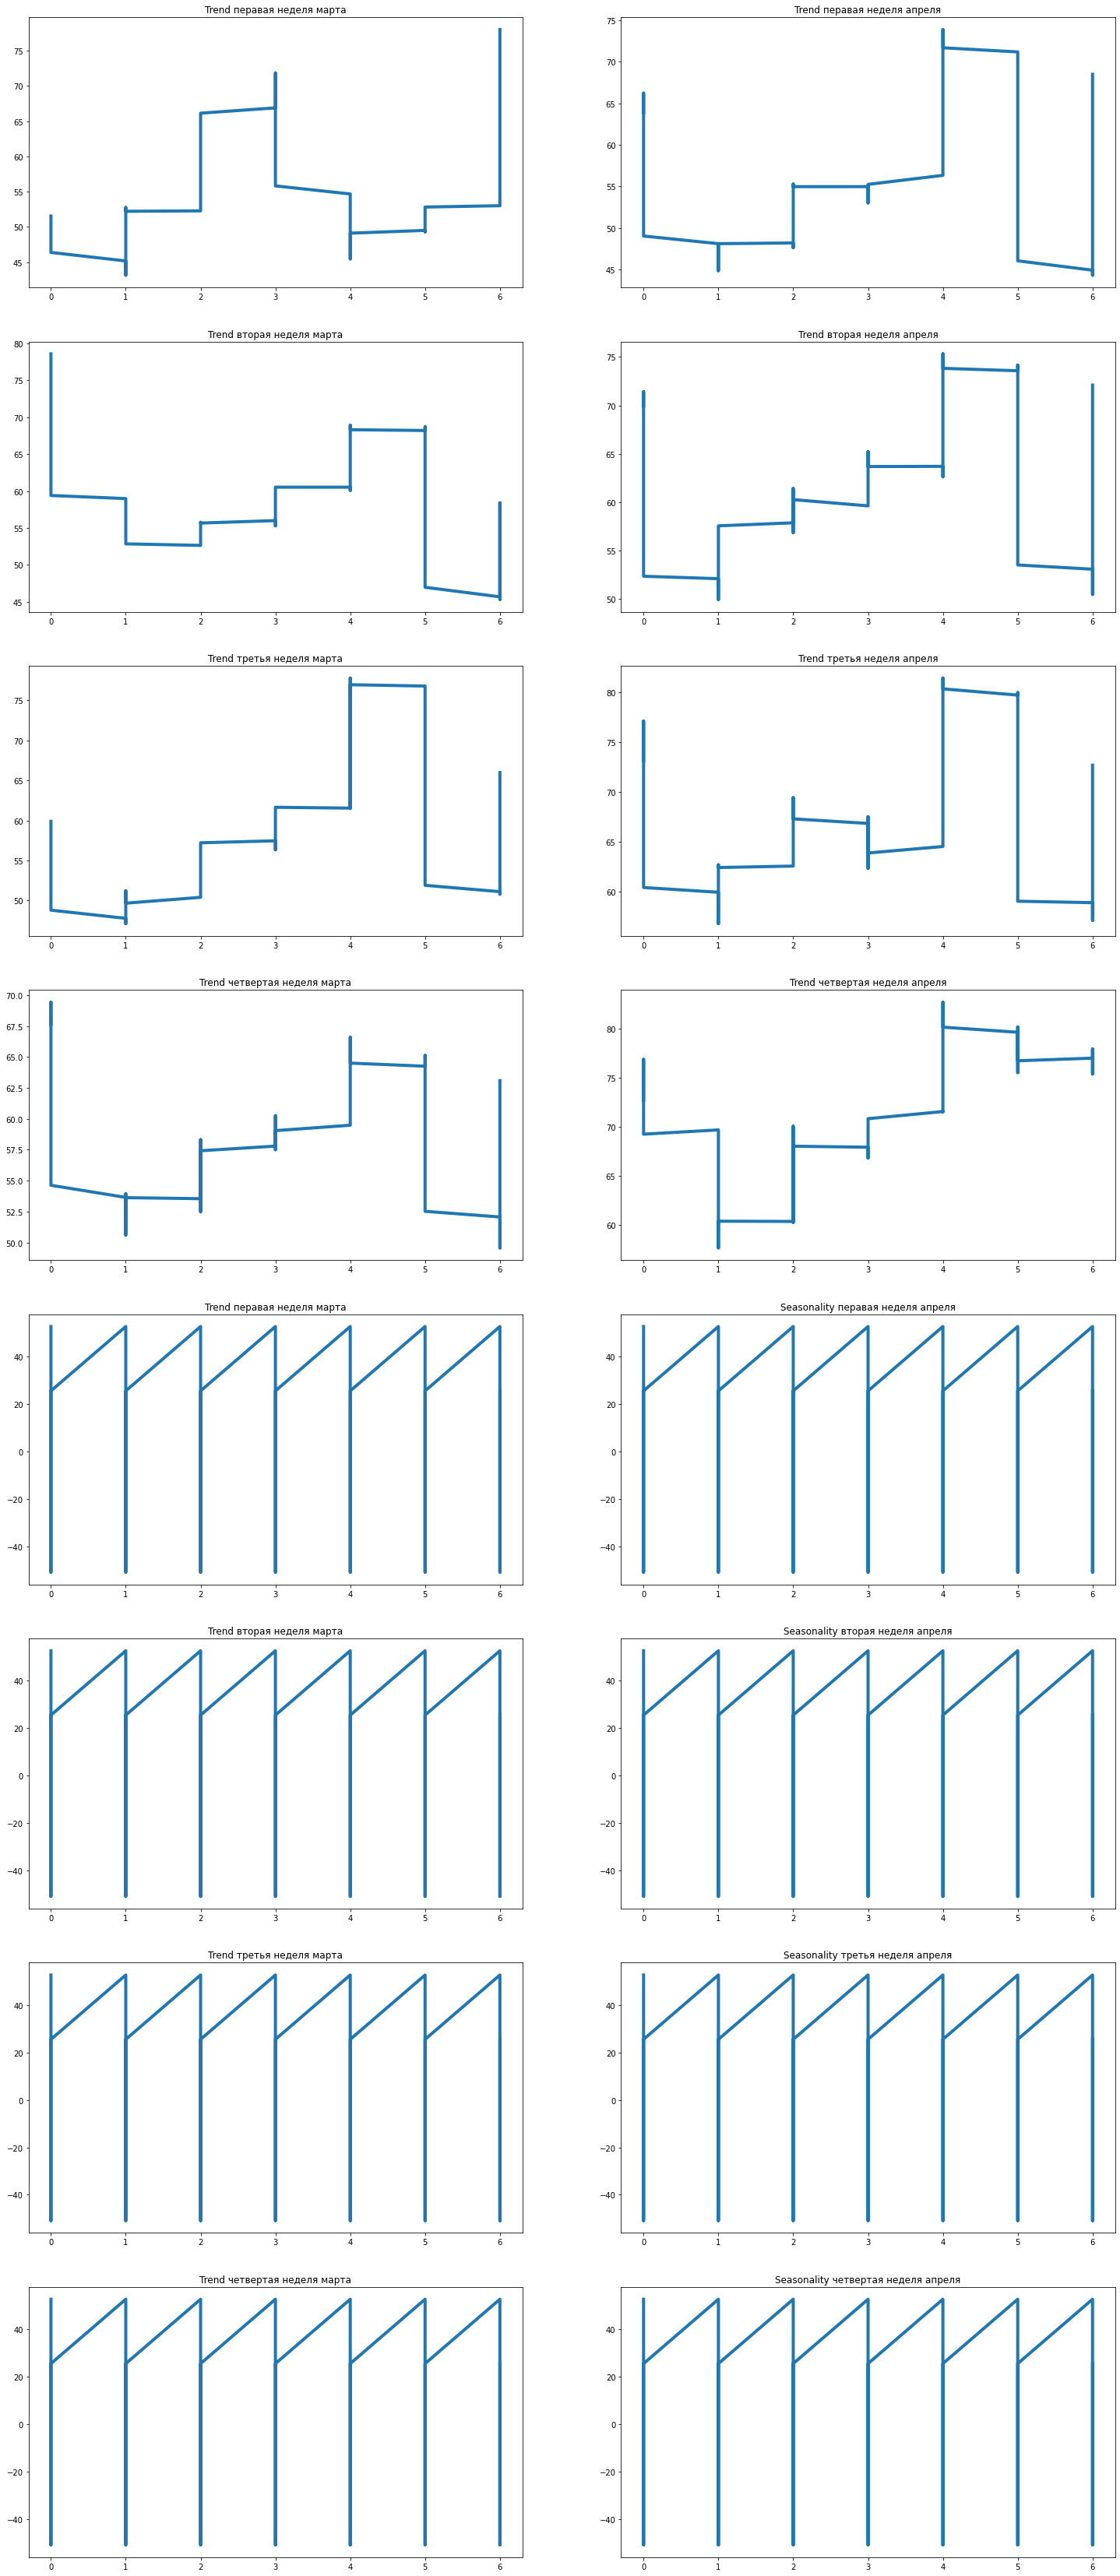

In [19]:
#так же рассмотрим сезонность на небольшом временном промежутке
decomposed_short = seasonal_decompose(final_frame["2018-03-05":"2018-04-29"]["num_orders"])
fig2,ax2 = plt.subplots(8,2,figsize = (25,60))
# Trend
    # Март
ax2[0][0].plot(decomposed_short.trend["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.trend["2018-03-05":"2018-03-11"].values,linewidth=4)
ax2[0][0].set_title("Trend перавая неделя марта")

ax2[1][0].plot(decomposed_short.trend["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.trend["2018-03-12":"2018-03-18"].values,linewidth=4)
ax2[1][0].set_title("Trend вторая неделя марта")

ax2[2][0].plot(decomposed_short.trend["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.trend["2018-03-19":"2018-03-25"].values,linewidth=4)
ax2[2][0].set_title("Trend третья неделя марта")

ax2[3][0].plot(decomposed_short.trend["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.trend["2018-03-26":"2018-04-01"].values,linewidth=4)
ax2[3][0].set_title("Trend четвертая неделя марта")

    # Апрель
ax2[0][1].plot(decomposed_short.trend["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.trend["2018-04-02":"2018-04-08"].values,linewidth=4)
ax2[0][1].set_title("Trend перавая неделя апреля")

ax2[1][1].plot(decomposed_short.trend["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.trend["2018-04-09":"2018-04-15"].values,linewidth=4)
ax2[1][1].set_title("Trend вторая неделя апреля")

ax2[2][1].plot(decomposed_short.trend["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.trend["2018-04-16":"2018-04-22"].values,linewidth= 4)
ax2[2][1].set_title("Trend третья неделя апреля")

ax2[3][1].plot(decomposed_short.trend["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.trend["2018-04-23":"2018-04-29"].values,linewidth= 4)
ax2[3][1].set_title("Trend четвертая неделя апреля")
# Seasonality
    # Март
ax2[4][0].plot(decomposed_short.seasonal["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.seasonal["2018-03-05":"2018-03-11"].values,linewidth=4)
ax2[4][0].set_title("Trend перавая неделя марта")

ax2[5][0].plot(decomposed_short.seasonal["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.seasonal["2018-03-12":"2018-03-18"].values,linewidth=4)
ax2[5][0].set_title("Trend вторая неделя марта")

ax2[6][0].plot(decomposed_short.seasonal["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.seasonal["2018-03-19":"2018-03-25"].values,linewidth=4)
ax2[6][0].set_title("Trend третья неделя марта")

ax2[7][0].plot(decomposed_short.seasonal["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.seasonal["2018-03-26":"2018-04-01"].values,linewidth=4)
ax2[7][0].set_title("Trend четвертая неделя марта")

    # Апрель
ax2[4][1].plot(decomposed_short.seasonal["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.seasonal["2018-04-02":"2018-04-08"].values,linewidth=4)
ax2[4][1].set_title("Seasonality перавая неделя апреля")

ax2[5][1].plot(decomposed_short.seasonal["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.seasonal["2018-04-09":"2018-04-15"].values,linewidth=4)
ax2[5][1].set_title("Seasonality вторая неделя апреля")

ax2[6][1].plot(decomposed_short.seasonal["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.seasonal["2018-04-16":"2018-04-22"].values,linewidth= 4)
ax2[6][1].set_title("Seasonality третья неделя апреля")

ax2[7][1].plot(decomposed_short.seasonal["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.seasonal["2018-04-23":"2018-04-29"].values,linewidth= 4)
ax2[7][1].set_title("Seasonality четвертая неделя апреля")

**Вывод**


1 марта 2018 это четверг, поэтому при рассмотрении недель, лучше будет взять даты с понедельника по воскресение, то есть с 5 марта по 29 апреля. Рассмотрим их на осях количество заказов и день недели, а не количество заказов и число месяца. Здесь мы можем увидеть,сезонность остается неизменной на протяжении всего исследуемого периода, в начале каждого дня у нас пик, потом резкое падение, затем в течение дня количество заказов растет и к концу дня достигает нового пика. Можно заметить тренд на рост числа заказов в понедельник, тренд на падение заказов во вторник, который со 2 недели апреля меняется на рост. А так же тренд на рост заказов во второй половине недели

### Подготовка даных

In [20]:
train,test = train_test_split(final_frame, shuffle = False, random_state = 42, test_size = 0.1)

In [21]:
train = train.dropna()

In [22]:
(train_features,
test_features) = (train.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(train_target,
test_target) = (train['num_orders'],
                test['num_orders'])

In [23]:
#Проверим размеры выборок
print('Размер обучающей выборки:', train_features.shape[0])
print('Размер тестовой выборки:', test_features.shape[0])

Размер обучающей выборки: 3950
Размер тестовой выборки: 442


**Вывод**


* данные проанализированы
* признаки созданы
* подготовка к обучению завершена

## Обучение

In [24]:
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)

In [25]:
# RandomForest
RF = RandomForestRegressor(random_state=42)
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}

RF_grid = GridSearchCV(RF,parametrs,cv = splits,verbose=True,n_jobs=-1)
RF_grid.fit(train_features,train_target)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150, 10]},
             verbose=True)

In [ ]:
# CatBoost
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 42)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(train_features,train_target),cv=splits,verbose=True)

0:	learn: 72.4520183	test: 107.4359799	best: 107.4359799 (0)	total: 52.6ms	remaining: 52.6s
1:	learn: 66.2711881	test: 99.8743571	best: 99.8743571 (1)	total: 56.7ms	remaining: 28.3s
2:	learn: 61.0197030	test: 94.1114227	best: 94.1114227 (2)	total: 60.7ms	remaining: 20.2s
3:	learn: 56.6153033	test: 89.2746170	best: 89.2746170 (3)	total: 64.6ms	remaining: 16.1s
4:	learn: 52.3834495	test: 84.1390374	best: 84.1390374 (4)	total: 68.5ms	remaining: 13.6s
5:	learn: 48.4860815	test: 79.3473279	best: 79.3473279 (5)	total: 72.1ms	remaining: 11.9s
6:	learn: 44.9854243	test: 75.0879599	best: 75.0879599 (6)	total: 76.7ms	remaining: 10.9s
7:	learn: 41.8845417	test: 71.0378335	best: 71.0378335 (7)	total: 80.7ms	remaining: 10s
8:	learn: 39.3438128	test: 67.8894876	best: 67.8894876 (8)	total: 84.4ms	remaining: 9.3s
9:	learn: 37.0248679	test: 64.7390186	best: 64.7390186 (9)	total: 88.4ms	remaining: 8.75s
10:	learn: 34.9942137	test: 61.8906356	best: 61.8906356 (10)	total: 92.5ms	remaining: 8.32s
11:	learn

In [ ]:
%%time
# LightGBM
lgb_train = lgb.Dataset(train_features,train_target)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train],
                verbose_eval=100)

In [ ]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(train_features,train_target))

In [ ]:
#предскажем значения разными моделями обучающей выборки
# Train
    # RandomForest
preds_RF_train = RF_grid.best_estimator_.predict(train_features)
    # CatBoost
preds_Cat_train = final_cat.predict(train_features)
    #LightGBM
preds_Light_train = light.predict(train_features)

In [ ]:
#Время предсказания на обучающей выборке
# Time Train
    # RandomForest
RF_train_start_time = time.time()
preds_RF_train = RF_grid.best_estimator_.predict(train_features)
RF_train_total_time = time.time() - RF_train_start_time
    # CatBoost
CatBoost_train_start_time = time.time()
preds_Cat_train = final_cat.predict(train_features)
CatBoost_train_total_time = time.time() - CatBoost_train_start_time
    #LightGBM
LightGBM_train_start_time = time.time()
preds_Light_train = light.predict(train_features)
LightGBM_train_total_time = time.time() - LightGBM_train_start_time

In [ ]:
#Вычислим метрику RMSE на обучающей выборке

#Train
    # RandomForest
RMSE_RF_train = (mean_squared_error(train_target,preds_RF_train))**0.5
    # CatBoost
RMSE_CatBoost_train = (mean_squared_error(train_target,preds_Cat_train))**0.5
    #LightGBM
RMSE_LightGBM_train = (mean_squared_error(train_target,preds_Light_train))**0.5

In [ ]:
#Составим таблицу, отражающую результаты исследования
report = pd.DataFrame(columns = ["RandomForest","CatBoost","LightGBM"],
                      index = ["RMSE(train)",
                               "Время обучения (секунды)",
                               "Время предсказания (секунды)"])


report.iloc[0] = [RMSE_RF_train, RMSE_CatBoost_train, RMSE_LightGBM_train]
report.iloc[1] = [5.2,1.62,1.44]
report.iloc[2] = [RF_train_total_time, CatBoost_train_total_time, LightGBM_train_total_time]
display(report)

**Вывод:**


* Наилучшие гиперпараметры найдены
* Модели обучены
* Модели прошли валидацию
* Подготовка к тестированию завершена (для тестовой выборки используем наилучшую модель, т.е. LightGBM, поскольку данная модель показала лучшую метрику RMSE и наименьшее время обучения)

## Тестирование

In [ ]:
# Найдем RMSE модели LightGBM на тестовой выборке
preds_Light_test = light.predict(test_features)
RMSE_LightGBM_test = (mean_squared_error(test_target,preds_Light_test))**0.5
print(RMSE_LightGBM_test)

In [ ]:
a = test_target.tolist()
b = preds_Light_test.tolist()
c = test_target.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

## Общий вывод
В ходе исследования обучили три модели RandomForest, CatBoost, LightGBM.
По условию задания RMSE должен быть не более 48. Отсюда следует, что нам подходят все модели, но наименьшую ошибку, а так же наименьшее время обучения показала модель построенная на алгоритме LightGBM, поэтому использовали её для тестовой выборки. RMSE на тестовой выборке оказалось равным 41, что удовлетворяет требованию заказчика.